# 0. Preterm Birth Prediction Using EHG

This project is using topological data analysis of electrohysterograph samples to predict preterm births. TRhe goal is to determine if TDA can enhance the classification of signals and subsequent prediction of preterm birth. 

Previous literature: use of persistent homology to classify electromyography signals (hand movements) https://www.proquest.com/openview/8312b24e2d9eb9f154c172d4705d4409/1?pq-origsite=gscholar&cbl=5444811

## Data Access  

https://physionet.org/content/tpehgdb/1.0.1/tpehgdb/

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

Gašper Fele-Žorž, Gorazd Kavšek, Živa Novak-Antolič and Franc Jager. A comparison of various linear and non-linear signal processing techniques to separate uterine EMG records of term and pre-term delivery groups. Medical & Biological Engineering & Computing, 46(9):911-922 (2008).

## Data Description

"The Term-Preterm EHG Database, a collection of electrohysterogram (EHG: uterine EMG) recordings obtained at the University Medical Centre Ljubljana from 300 pregnant women, has been contributed to PhysioNet. The collection includes recordings from 262 women who had full-term pregnancies and 38 whose pregnancies ended prematurely; 162 of the recordings were made before the 26th week of gestation, and 138 later."

Each record is composed of three channels, recorded from 4 electrodes (E1, E2, E3, E4).  
The differences in the electrical potentials of the electrodes were recorded, producing 3 channels:  
 - S1 = E2–E1 (first channel)
 - S2 = E2–E3 (second channel)  
 - S3 = E4–E3 (third channel)  

The individual records are 30 minutes in duration. Each signal has been digitized at 20 samples per second per channel with 16-bit resolution over a range of ±2.5 millivolts.  

Each signal was digitally filtered using 3 different 4-pole digital Butterworth filters with a double-pass filtering scheme. The band-pass cut-off frequencies were:  

 - 0.08Hz to 4Hz
 - 0.3Hz to 3Hz
 - 0.3Hz to 4Hz

When using filtered channels, note that the first and last 180 seconds of the signals should be ignored since these intervals contain transient effects of the filters. (first and last 3600 samples)

The records in the database contain both the original and filtered signals. The records are in WFDB format. Each record consists of two files, a header file (.hea) containing information regarding the record and the data file (.dat) containing signal data.

An accompanying file (tpehgdb.smr) summarizes clinical information of each record, describing whether the corresponding pregnancy ended on term (> 37 weeks) or prematurely (≤ 37 weeks), and whether the record was obtained before the 26th week of gestation or during or after the 26th week of gestation.  

Visualize the waveform: https://physionet.org/lightwave/?db=tpehgdb/1.0.1  

## Virtual Environment 
my virtual environment name: ehg_preterm   
Best practices is to activate the virtual environment from CLI (see git bash example below)  
Navigate to project directory  
 source ./ehg_preterm/Scripts/activate  
 deactivate  

## Requirements
jupyter  
pandas  
numpy  
scikit-learn  
matplotlib  
seaborn  
wfdb #for waveform data  
tensorflow  
glob  
ripser
install ydata-profiling to use pandas_profiling

### ripser requirements for Windows
- MinGW-w64 for Windows https://winlibs.com/ (also make sure to update system Path)
- Microsoft C++ Build Tools "Desktop development with C++" workload https://visualstudio.microsoft.com/visual-cpp-build-tools/
- install cython before installing ripser


### wfdb readthedocs
https://wfdb.readthedocs.io/en/latest/wfdb.html

### smr filetype
This filetype is proprietary to Spike2 by Cambridge Electronic Design. I did not have luck parsing it with python, so I used https://filext.com/file-extension/SMR, pasted into a txt file and read it to csv. This would not be ideal with larger files.  

## Import packages

In [66]:
import numpy as np
import pandas as pd
from io import StringIO

# For waveform data and handling
import wfdb
import os
import glob

# For TDA
import cython
import ripser
from ripser import ripser
from ripser import Rips

# For data visualization
import matplotlib
import seaborn
import matplotlib.pyplot as plt
from persim import plot_diagrams
import ydata_profiling
from pandas_profiling import ProfileReport
#from IPython.display import display, HTML

# For ML Modeling
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 1. Inspect Data 
.dat and .hea files from database tpehgdb

## Visualize one patient waveform record

Thank you to ProtoBioengineering for the tutorial: https://medium.com/@protobioengineering/how-to-get-heart-data-from-the-mit-bih-arrhythmia-database-e452d4bf7215 

record found


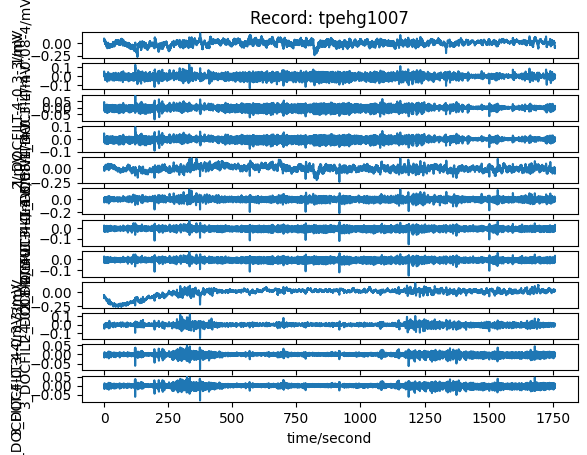

should have ploitted


In [2]:
patient_record = wfdb.rdrecord("/home/katie_grillaert/ehg_preterm/tpehgdb/tpehg1007")
print("record found")
wfdb.plot_wfdb(patient_record) # Visualization of 12 channels (sensors/leads) for the patient record 
print("should have ploitted")
plt.show()

In [90]:
print(patient_record.__dict__) # Dictionary of metadata

{'record_name': 'tpehg1007', 'n_sig': 12, 'fs': 20, 'counter_freq': None, 'base_counter': None, 'sig_len': 35180, 'base_time': None, 'base_date': None, 'comments': ['Comments:', 'RecID 1007', 'Gestation 35', 'Rectime 31.3', 'Age 30', 'Parity 0', 'Abortions 0', 'Weight 58', 'Hypertension no', 'Diabetes no', 'Placental_position front', 'Bleeding_first_trimester no', 'Bleeding_second_trimester no', 'Funneling negative', 'Smoker no'], 'sig_name': ['1', '1_DOCFILT-4-0.08-4', '1_DOCFILT-4-0.3-3', '1_DOCFILT-4-0.3-4', '2', '2_DOCFILT-4-0.08-4', '2_DOCFILT-4-0.3-3', '2_DOCFILT-4-0.3-4', '3', '3_DOCFILT-4-0.08-4', '3_DOCFILT-4-0.3-3', '3_DOCFILT-4-0.3-4'], 'p_signal': array([[ 0.08339055,  0.00244144,  0.00076295, ..., -0.00053407,
        -0.00015259, -0.00053407],
       [ 0.0873579 ,  0.01396201,  0.00518807, ..., -0.00320439,
        -0.00099184, -0.00297551],
       [ 0.08224613,  0.03486687,  0.0156405 , ..., -0.00793469,
        -0.0030518 , -0.00686656],
       ...,
       [-0.07988098,

In [83]:
# Per wfdb dot notation, metadata can be accessed via patient_record.XYZ
patient_number = patient_record.record_name
leads = patient_record.sig_name # Names of leads and filtered leads 
comments = patient_record.comments
sig_len = patient_record.sig_len # Number of samples

In [89]:
print(patient_number)
print(leads)
print(comments)
print(sig_len)

tpehg1007
['1', '1_DOCFILT-4-0.08-4', '1_DOCFILT-4-0.3-3', '1_DOCFILT-4-0.3-4', '2', '2_DOCFILT-4-0.08-4', '2_DOCFILT-4-0.3-3', '2_DOCFILT-4-0.3-4', '3', '3_DOCFILT-4-0.08-4', '3_DOCFILT-4-0.3-3', '3_DOCFILT-4-0.3-4']
['Comments:', 'RecID 1007', 'Gestation 35', 'Rectime 31.3', 'Age 30', 'Parity 0', 'Abortions 0', 'Weight 58', 'Hypertension no', 'Diabetes no', 'Placental_position front', 'Bleeding_first_trimester no', 'Bleeding_second_trimester no', 'Funneling negative', 'Smoker no']
35180


## Extract signal data to csv
Write loop that extracts relevant information; each patient to one csv. 
Thank you to Abhishek Patil: https://github.com/abhilampard/Physionet-CSV-Conversion/blob/master/script.py

In [93]:
# Check current working directory
os.getcwd()

#Change working directory if necessary
#os.chdir('/home/katie_grillaert/ehg_preterm/tpehgdb')

'/home/katie_grillaert/ehg_preterm/tpehgdb'

In [ ]:
# Code to convert all .dat files (ECG signals) in a folder to CSV format 
# @author: Abhishek Patil

# THIS CODE IMPORTS 12 cols, one for each lead, with the first line as the header. 
#dat_files = glob.glob('*.dat') #Get list of all .dat files in the current folder
#df=pd.DataFrame(data=dat_files)
#df.to_csv("files_list.csv",index=False,header=None) #Write the list to a CSV file
#files=pd.read_csv("files_list.csv",header=None)

#Given the master csv, write the data to a csv for each patient:

dat_files = glob.glob('*.dat')  # Get list of all .dat files in the current folder

df = pd.DataFrame(data=dat_files)
df.to_csv("/home/katie_grillaert/ehg_preterm/files_list.csv", index=False, header=None)  # Write the list to a CSV file
files = pd.read_csv("/home/katie_grillaert/ehg_preterm/files_list.csv", header=None)
output_directory = "/home/katie_grillaert/ehg_preterm" 

for i in range(1, len(files) + 1):
    recordname = str(files.iloc[[i]])
    
    # Replace multiple consecutive spaces with a single space
    recordname = ' '.join(recordname.split())

    # Remove leading/trailing spaces
    recordname = recordname.strip()

    # Replace newline characters in the file name
    recordname = recordname.replace('\n', '')

    # Initialize the recordname_new variable
    recordname_new = ""

    try:
        # Try with original extraction
        recordname_new = recordname[-13:-4]
        record = wfdb.rdsamp(recordname_new)  # rdsamp() returns the signal as a numpy array
    except FileNotFoundError:
        try:
            # Retry with alternative extraction
            recordname_new = recordname[-12:-4]
            record = wfdb.rdsamp(recordname_new)  # rdsamp() returns the signal as a numpy array
        except FileNotFoundError:
            # If both attempts fail, skip this file
            print(f"File not found: {recordname}")
            continue

    record = np.asarray(record[0])

    path = recordname_new + ".csv"
    np.savetxt(path, record, delimiter=",")  # Writing the CSV for each record
    print("Files done: %s/%s" % (i, len(files)))

print("\nAll files done!")


### Inspect one csv example

In [2]:
df = pd.read_csv("/home/katie_grillaert/ehg_preterm/tpehgdb/tpehg1021.csv", header=None)

In [ ]:
df

28060


## Examine hea files ("comments" metadata)

In [96]:
hea_file_path = '/home/katie_grillaert/ehg_preterm/tpehgdb/tpehg1484'

# Load the HEA file
hea_record = wfdb.rdheader(hea_file_path)

# Display general information about the record
print(f"Record Name: {hea_record.record_name}")
print(f"Number of Channels: {hea_record.n_sig}")
print(f"Sampling Frequency: {hea_record.fs} Hz")
print(f"Signal Labels: {hea_record.sig_name}")
print(f"Comments: {hea_record.comments}")

# Display detailed information about each signal/channel
#for i, signal in enumerate(hea_record.sig_name):
 #   print(f"\nSignal {i + 1} - {signal}")
  #  print(f"Label: {hea_record.sig_name[i]}")
   # print(f"Units: {hea_record.units[i]}")
   # print(f"ADC Gain: {hea_record.adc_gain[i]}")
   # print(f"ADC Resolution: {hea_record.adc_res[i]}")
   # print(f"Baseline: {hea_record.baseline[i]}")



Record Name: tpehg1484
Number of Channels: 12
Sampling Frequency: 20.00011 Hz
Signal Labels: ['1', '1_DOCFILT-4-0.08-4', '1_DOCFILT-4-0.3-3', '1_DOCFILT-4-0.3-4', '2', '2_DOCFILT-4-0.08-4', '2_DOCFILT-4-0.3-3', '2_DOCFILT-4-0.3-4', '3', '3_DOCFILT-4-0.08-4', '3_DOCFILT-4-0.3-3', '3_DOCFILT-4-0.3-4']
Comments: ['Comments:', 'RecID 1484', 'Gestation 40', 'Rectime 22.3', 'Age 32', 'Parity 1', 'Abortions 0', 'Weight 63', 'Hypertension no', 'Diabetes no', 'Placental_position front', 'Bleeding_first_trimester yes', 'Bleeding_second_trimester no', 'Funneling negative', 'Smoker no']


In [74]:
# Load the HEA file
hea_file_path = '/home/katie_grillaert/ehg_preterm/tpehgdb/tpehg1484'
hea_record = wfdb.rdheader(hea_file_path)

# Extract comments from the record
comments = hea_record.comments

# Create a DataFrame with comments as columns
df = pd.DataFrame({'Comment{}'.format(i + 1): [comment] for i, comment in enumerate(comments)})

# Specify the desired CSV file path
csv_file_path = '/home/katie_grillaert/ehg_preterm/tpehg1484_comments.csv'

# Save DataFrame to CSV
df.to_csv(csv_file_path, index=False)

print(f"Comments have been saved to {csv_file_path}")

Comments have been saved to /home/katie_grillaert/ehg_preterm/tpehg1484_comments.csv


In [75]:
df_header = pd.read_csv("/home/katie_grillaert/ehg_preterm/tpehg1484_comments.csv")
df_header

,Comment1,Comment2,Comment3,Comment4,Comment5,Comment6,Comment7,Comment8,Comment9,Comment10,Comment11,Comment12,Comment13,Comment14,Comment15
0,Comments:,RecID 1484,Gestation 40,Rectime 22.3,Age 32,Parity 1,Abortions 0,Weight 63,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker no


## Analyse persistent homology for one record

### Filtration information

maxdim (int, optional, default 1) – Maximum homology dimension computed. Will compute all dimensions lower than and equal to this value. For 1, H_0 and H_1 will be computed.  
thresh (float, default infinity) – Maximum distances considered when constructing filtration. If infinity, compute the entire filtration.  
coeff (int prime, default 2) – Compute homology with coefficients in the prime field Z/pZ for p=coeff.  
do_cocycles (bool) – Indicator of whether to compute cocycles, if so, we compute and store cocycles in the cocycles_ dictionary Rips member variable  
n_perm (int) – The number of points to subsample in a “greedy permutation,” or a furthest point sampling of the points. These points will be used in lieu of the full point cloud for a faster computation, at the expense of some accuracy, 
which can be bounded as a maximum bottleneck distance to all diagrams on the original point set  
verbose (boolean) – Whether to print out information about this object as it is constructed  

https://ripser.scikit-tda.org/en/latest/reference/stubs/ripser.Rips.html   


### Visualize persistence diagram 

sample prepared
result calculated


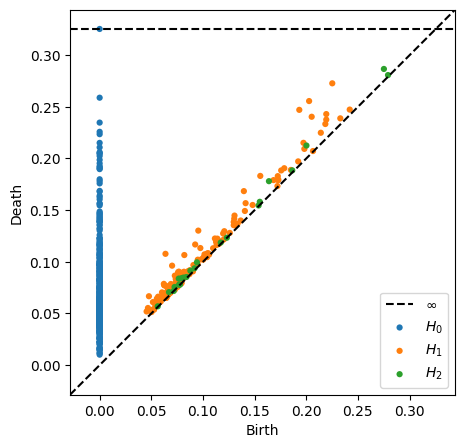

In [4]:
#So much data... will need to research proper way to filter and create sparse matrix, and probably sample on top of that. For now, a simple sample. 
sample_fraction = 0.01
df_sample = df.sample(frac=sample_fraction, random_state=42) 
print("sample prepared")

result = ripser(df_sample, maxdim=2, coeff=2)
print("result calculated")

# Plot the persistent homology diagram
plt.figure(figsize=(10, 5))
diagrams = (result)['dgms']
plot_diagrams(diagrams, show=True)

In [77]:
df.columns = df.columns.astype(str)

new_column_names = {'0': 's1_unfilt', 
                    '1': 's1_filter_a', 
                    '2': 's1_filter_b',
                    '3': 's1_filter_c',
                    '4': 's2_unfilt', 
                    '5': 's2_filter_a', 
                    '6': 's2_filter_b',
                    '7': 's2_filter_c',
                    '8': 's3_unfilt', 
                    '9': 's3_filter_a', 
                    '10': 's3_filter_b',
                    '11': 's3_filter_c'}

df.rename(columns=new_column_names, inplace=True)


df

,Comment1,Comment2,Comment3,Comment4,Comment5,Comment6,Comment7,Comment8,Comment9,Comment10,Comment11,Comment12,Comment13,Comment14,Comment15
0,Comments:,RecID 1484,Gestation 40,Rectime 22.3,Age 32,Parity 1,Abortions 0,Weight 63,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker no


### Examine dictionary of results

In [ ]:
# Print keys
print("Keys:", list(result.keys()))

# Print values
#print("Values:", list(result.values()))

# Print key-value pairs (items)
#print("Items:", list(result.items()))

#dgms_value = result['dgms']
#print("Contents of 'dgms':", dgms_value)


### Extract Betti numbers

In [ ]:
if 'dgms' in result:
    persistence_diagrams = result['dgms']

    # Extract Betti-0 numbers
    betti_0_numbers = sum(np.isfinite(persistence_diagrams[0][:, 1]))
    print("Betti-0 Numbers:", betti_0_numbers)

    # Extract Betti-1 numbers
    betti_1_numbers = sum(np.isfinite(persistence_diagrams[1][:, 1]))
    print("Betti-1 Numbers:", betti_1_numbers)

    # Extract Betti-2 numbers
    betti_2_numbers = sum(np.isfinite(persistence_diagrams[2][:, 1]))
    print("Betti-2 Numbers:", betti_2_numbers)

else:
    print("The 'dgms' key is not present in the dictionary.")


### View patient record

In [ ]:
# View result dictionary for patient record
print(result)

In [78]:
file_path = r'tpehg914'

# Read the WFDB record
record_inspect = wfdb.rdrecord(file_path)

# Print the record object
print(record_inspect)

# Access the raw signal data
raw_data = record_inspect.p_signal
print(raw_data)

[[ 5.72213321e-03 -1.52590219e-04  0.00000000e+00 ... -3.81475547e-04
  -1.52590219e-04 -3.81475547e-04]
 [ 5.56954299e-03 -1.06813153e-03  7.62951095e-05 ... -2.44144350e-03
  -9.91836423e-04 -2.28885328e-03]
 [ 3.05180438e-03 -2.97550927e-03  1.52590219e-04 ... -6.48508431e-03
  -3.12809949e-03 -5.95101854e-03]
 ...
 [ 2.18204013e-02  2.62455177e-02  1.14442664e-03 ... -1.89974823e-02
  -2.97550927e-03 -2.13626307e-03]
 [ 2.17441062e-02  2.47196155e-02 -1.52590219e-04 ... -1.77767605e-02
  -1.22072175e-03 -2.28885328e-04]
 [ 2.30411231e-02  1.78530556e-02 -1.06813153e-03 ... -1.27412833e-02
   1.52590219e-04  5.34065766e-04]]


# 2. Apply Ripser and Extract Betti Numbers
- Read in csv files
- Format column names and subset columns into groups based on filter (unfiltered, filter a, filter b, filter c; 3 columns per filter)
- Apply ripser and save results in dictionary
- Extract Betti numbers from dictionary
- Save results as csv per each subset

In [ ]:
# Loop to compile results list for multiple records

for i in range(4):
    
    subset = f"Subset_{i}"
    
    # Set the folder path where CSV files are located
    folder_path = r'/home/katie_grillaert/ehg_preterm/tpehgdb'

    # Set the sample fraction
    sample_fraction = 0.01

    # Initialize a counter variable
    counter = 0
    
    # Dictionary to store results with filenames as keys
    all_results = {}
    
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(folder_path + '/*.csv')

    # Loop through each CSV file
    for csv_file in csv_files:
        
        # Increment the counter
        counter += 1
    
        # Extract the filename without the path
        filename = os.path.basename(csv_file)
   
        # Extract the desired part of the filename, e.g., without the extension
        key = filename.replace('.csv', '')

        # Read CSV file into a DataFrame
        df_filename = pd.read_csv(csv_file, header=None)

        # Print the file number and total number of files
        print(f"Processing file {counter} of {len(csv_files)}", filename)    
    
        # Select only numeric columns
        numeric_columns = df_filename.select_dtypes(include=['number'])

        # Check if there is at least one numeric column
        if not numeric_columns.empty:

            # Rename cols
            numeric_columns.columns = numeric_columns.columns.astype(str)
                
            new_column_names = {'0': 's1_unfilt', 
                             '1': 's1_filter_a', 
                             '2': 's1_filter_b',
                             '3': 's1_filter_c',
                             '4': 's2_unfilt', 
                             '5': 's2_filter_a', 
                             '6': 's2_filter_b',
                             '7': 's2_filter_c',
                             '8': 's3_unfilt', 
                             '9': 's3_filter_a', 
                             '10': 's3_filter_b',
                             '11': 's3_filter_c'}

            numeric_columns.rename(columns=new_column_names, inplace=True)
            print("cols renamed")

            if subset != "Subset_0":
                # Remove the first 3600 rows
                numeric_columns = numeric_columns.iloc[3600:]
                # Remove the last 3600 rows
                numeric_columns = numeric_columns.iloc[:-3600]
            
            # Select only columns for sensor groups
            unfilt_group = ['s1_unfilt', 's2_unfilt', 's3_unfilt']
            filt_a_group = ['s1_filter_a', 's2_filter_a', 's3_filter_a']
            filt_b_group = ['s1_filter_b', 's2_filter_b', 's3_filter_b']
            filt_c_group = ['s1_filter_c', 's2_filter_c', 's3_filter_c']
            
            # Create df subsets
            unfilt_df = numeric_columns[unfilt_group]
            filt_a_df = numeric_columns[filt_a_group]
            filt_b_df = numeric_columns[filt_b_group]
            filt_c_df = numeric_columns[filt_c_group]
                
            # Choose the appropriate subset dataframe based on the current iteration
            if subset == "Subset_0":
                subset_df = unfilt_df
            elif subset == "Subset_1":
                 subset_df = filt_a_df
            elif subset == "Subset_2":
                subset_df = filt_b_df
            elif subset == "Subset_3":
                subset_df = filt_c_df
            else:
                raise ValueError(f"Unknown subset: {subset}")
            
            # Take a sample of the DataFrame
            df_filename_sample = subset_df.sample(frac=sample_fraction, random_state=42)

            # Perform persistent homology analysis
            result_filename = ripser(df_filename_sample, maxdim=2, coeff=2, metric='euclidean')
    
            # Add the 'filename' key to the result dictionary
            result_filename['filename'] = key

            # Store the result in the dictionary with the modified filename as the key
            all_results[key] = result_filename
        
        else:
            print("No numeric columns found in the DataFrame.")
    
    # Now, all_results contains the results for each patient with filenames as keys
    print("Subset", i, "completed")

    # Create lists to store betti numbers and filenames
    betti_numbers_list = []
    filenames_list = []

    for filename, result in all_results.items():
        # Check if 'dgms' key is present
        if 'dgms' in result:
            persistence_diagrams = result['dgms']

            # Extract Betti-0 numbers
            betti_0_numbers = sum(np.isfinite(persistence_diagrams[0][:, 1]))

            # Extract Betti-1 numbers
            betti_1_numbers = sum(np.isfinite(persistence_diagrams[1][:, 1]))

            # Extract Betti-2 numbers
            betti_2_numbers = sum(np.isfinite(persistence_diagrams[2][:, 1]))

            # Extract the filename without the extension
            filename = result.get('filename', 'unknown')

            # Append betti numbers and filename to the lists
            betti_numbers_list.append([betti_0_numbers, betti_1_numbers, betti_2_numbers])
            filenames_list.append(filename)

        else:
            print("The 'dgms' key is not present in the dictionary.")
        
    # Create a DataFrame from the lists
    df_betti_numbers = pd.DataFrame(betti_numbers_list, columns=[f'Betti_0_{subset}', f'Betti_1_{subset}', f'Betti_2_{subset}'])

    # Add the 'filename' column to the DataFrame
    df_betti_numbers['filename'] = filenames_list

    # Generate the output CSV filename dynamically based on the current subset
    output_csv_filename = f'/home/katie_grillaert/ehg_preterm/betti_numbers_{subset}.csv'

    # Save the DataFrame to the CSV file
    df_betti_numbers.to_csv(output_csv_filename, index=False)

    print(f"Results saved to: {output_csv_filename}")

# 3. Data Cleaning

## Prepare master dataframe

### Read in hea file to csv for all records

In [15]:
# Directory path containing HEA files
hea_directory = '/home/katie_grillaert/ehg_preterm/tpehgdb/'

# Use glob to get all HEA files in the directory
hea_files = glob.glob(os.path.join(hea_directory, '*.hea'))

# Initialize an empty list to store rows
rows = []

# Process each HEA file
for hea_file_path in hea_files:
    # Extract file name without extension
    file_name = os.path.splitext(os.path.basename(hea_file_path))[0]

    print(file_name)
    # Check if the corresponding .hea file exists
    if os.path.exists(hea_file_path):
        # Load the HEA file
        hea_record = wfdb.rdheader(file_name)

        # Extract comments from the record
        comments = hea_record.comments

        # Create a dictionary representing a row
        row_dict = {'filename': file_name}
        for idx, comment in enumerate(comments):
            row_dict[f'Comment{idx + 1}'] = comment

        # Append the row dictionary to the list
        rows.append(row_dict)

# Create a DataFrame from the list of rows
df_all_comments = pd.DataFrame(rows)

# Specify the desired CSV file path
csv_file_path = '/home/katie_grillaert/ehg_preterm/all_comments.csv'

# Save the main DataFrame to CSV
df_all_comments.to_csv(csv_file_path, index=False)

print(f"Comments for all HEA files have been saved to {csv_file_path}")


tpehg1250


FileNotFoundError: [Errno 2] No such file or directory: '/home/katie_grillaert/ehg_preterm/tpehg1250.hea'

In [ ]:
all_comments_df = pd.read_csv("/home/katie_grillaert/ehg_preterm/all_comments.csv")
all_comments_df

### Read in metadata from smr file

In [ ]:
file_path = '/home/katie_grillaert/ehg_preterm/smr.txt'

Read the content of the file
with open(file_path, 'r') as file:
    content = file.read()

# Use StringIO to convert the content to a file-like object
data = StringIO(content)

# Read the data into a DataFrame
df = pd.read_csv(file_path, sep='|', skipinitialspace=True, skipfooter=1, engine='python', header = 0)

smr_df.rename(columns={'Record    ': 'filename'}, inplace=True)
smr_df.rename(columns={' Gestation ': 'Gestation'}, inplace=True)
smr_df.rename(columns={' Rec. time ': 'Rec_time'}, inplace=True)
smr_df.rename(columns={'   Group   ': 'Group'}, inplace=True)
smr_df.rename(columns={' Premature ': 'Premature'}, inplace=True)
smr_df.rename(columns={' Early ': 'Early'}, inplace=True)


smr_df.to_csv('/home/katie_grillaert/ehg_preterm/smr.csv', index=False)
smr_df

In [ ]:
#smr_df.columns

# Remove leading and trailing spaces from all entries in the DataFrame
#smr_df = smr_df.map(lambda x: x.strip() if isinstance(x, str) else x)

# Display the updated DataFrame
#smr_df
#smr_df.to_csv('/home/katie_grillaert/ehg_preterm/smr.csv', index=False)


### Merge Betti numbers, smr metadata, and Comments on filename 

In [16]:
betti_0 = pd.read_csv("/home/katie_grillaert/ehg_preterm/betti_numbers_Subset_0.csv")
betti_1 = pd.read_csv("/home/katie_grillaert/ehg_preterm/betti_numbers_Subset_1.csv")
betti_2 = pd.read_csv("/home/katie_grillaert/ehg_preterm/betti_numbers_Subset_2.csv")
betti_3 = pd.read_csv("/home/katie_grillaert/ehg_preterm/betti_numbers_Subset_3.csv")
smr = pd.read_csv("/home/katie_grillaert/ehg_preterm/smr.csv")
comments = pd.read_csv("/home/katie_grillaert/ehg_preterm/all_comments.csv")

# Merge betti DataFrames one by one
merged_df = pd.merge(betti_0, betti_1, on='filename', how='inner')
merged_df = pd.merge(merged_df, betti_2, on='filename', how='inner')
merged_df = pd.merge(merged_df, betti_3, on='filename', how='inner')

# Merge with smr DataFrame
merged_df = pd.merge(merged_df, smr, on='filename', how='inner')

# Merge with comments DataFrame
merged_df = pd.merge(merged_df, comments, on='filename', how='inner')

ehgdf = merged_df.copy()
ehgdf

,Betti-0_Subset_0,Betti_1_Subset_0,Betti_2_Subset_0,filename,Betti-0_Subset_1,Betti_1_Subset_1,Betti_2_Subset_1,Betti-0_Subset_2,Betti_1_Subset_2,Betti_2_Subset_2,...,Comment6,Comment7,Comment8,Comment9,Comment10,Comment11,Comment12,Comment13,Comment14,Comment15
0,359,100,5,tpehg1484,287,75,0,287,83,2,...,Parity 1,Abortions 0,Weight 63,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker no
1,352,129,10,tpehg679,280,98,13,280,104,14,...,Parity 0,Abortions 1,Weight 62,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
2,359,112,9,tpehg1546,287,101,9,287,88,10,...,Parity 0,Abortions 0,Weight 66,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
3,359,125,18,tpehg1348,287,100,19,287,106,10,...,Parity 0,Abortions 2,Weight 66,Hypertension no,Diabetes no,Placental_position end,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
4,359,114,8,tpehg1526,287,85,6,286,94,5,...,Parity 1,Abortions 2,Weight 70,Hypertension None,Diabetes None,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,359,105,14,tpehg1628,202,69,6,202,68,15,...,Parity 1,Abortions 1,Weight 80,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
295,359,123,20,tpehg1585,287,104,6,287,105,14,...,Parity 0,Abortions 0,Weight 75,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
296,352,140,19,tpehg1136,280,116,12,280,106,11,...,Parity 0,Abortions 0,Weight 56,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
297,359,136,20,tpehg1338,287,114,14,287,113,16,...,Parity 1,Abortions 0,Weight 84,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no


In [17]:
ehgdf.to_csv('ehgdf.csv', index=False)

In [18]:
ehgdf = pd.read_csv('ehgdf.csv')
pd.set_option('display.max_columns', None)
ehgdf

,Betti-0_Subset_0,Betti_1_Subset_0,Betti_2_Subset_0,filename,Betti-0_Subset_1,Betti_1_Subset_1,Betti_2_Subset_1,Betti-0_Subset_2,Betti_1_Subset_2,Betti_2_Subset_2,Betti-0_Subset_3,Betti_1_Subset_3,Betti_2_Subset_3,Gestation,Rec_time,Group,Premature,Early,Comment1,Comment2,Comment3,Comment4,Comment5,Comment6,Comment7,Comment8,Comment9,Comment10,Comment11,Comment12,Comment13,Comment14,Comment15
0,359,100,5,tpehg1484,287,75,0,287,83,2,287,83,6,40.00,22.29,<26-TERM,f,t,Comments:,RecID 1484,Gestation 40,Rectime 22.3,Age 32,Parity 1,Abortions 0,Weight 63,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker no
1,352,129,10,tpehg679,280,98,13,280,104,14,280,99,11,39.86,23.71,<26-TERM,f,t,Comments:,RecID 679,Gestation 39.9,Rectime 23.7,Age 28,Parity 0,Abortions 1,Weight 62,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
2,359,112,9,tpehg1546,287,101,9,287,88,10,287,102,17,39.71,24.00,<26-TERM,f,t,Comments:,RecID 1546,Gestation 39.7,Rectime 24,Age 31,Parity 0,Abortions 0,Weight 66,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
3,359,125,18,tpehg1348,287,100,19,287,106,10,287,110,16,41.00,25.00,<26-TERM,f,t,Comments:,RecID 1348,Gestation 41,Rectime 25,Age 31,Parity 0,Abortions 2,Weight 66,Hypertension no,Diabetes no,Placental_position end,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
4,359,114,8,tpehg1526,287,85,6,286,94,5,287,79,8,29.29,24.71,<26-PRE,t,t,Comments:,RecID 1526,Gestation 29.3,Rectime 24.7,Age 36,Parity 1,Abortions 2,Weight 70,Hypertension None,Diabetes None,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,359,105,14,tpehg1628,202,69,6,202,68,15,202,70,5,39.29,30.57,>=26-TERM,f,f,Comments:,RecID 1628,Gestation 39.3,Rectime 30.6,Age 31,Parity 1,Abortions 1,Weight 80,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
295,359,123,20,tpehg1585,287,104,6,287,105,14,287,117,16,38.57,22.86,<26-TERM,f,t,Comments:,RecID 1585,Gestation 38.6,Rectime 22.9,Age 24,Parity 0,Abortions 0,Weight 75,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
296,352,140,19,tpehg1136,280,116,12,280,106,11,280,101,12,40.00,23.00,<26-TERM,f,t,Comments:,RecID 1136,Gestation 40,Rectime 23,Age 32,Parity 0,Abortions 0,Weight 56,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
297,359,136,20,tpehg1338,287,114,14,287,113,16,287,96,15,39.71,31.43,>=26-TERM,f,f,Comments:,RecID 1338,Gestation 39.7,Rectime 31.4,Age 29,Parity 1,Abortions 0,Weight 84,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no


## Prepare columns

### Rename columns

In [19]:
# Dictionary to map old column names to new column names

cols_to_drop=["Comment1", "Comment2", "Comment3", "Comment4"]
ehgdf.drop(columns=cols_to_drop, inplace=True)

column_order = ["filename"] + [col for col in ehgdf.columns if col != "filename"]
ehgdf = ehgdf[column_order]


column_mapping = {
    'Comment5': 'Age',
    'Comment6': 'Parity',
    'Comment7': 'Abortions',
    'Comment8': 'Weight',
    'Comment9': 'Hypertension',
    'Comment10': 'Diabetes',
    'Comment11': 'Placental_pos',
    'Comment12': 'Bleeding_first_tri',
    'Comment13': 'Bleeding_second_tri',
    'Comment14': 'Funneling',
    'Comment15': 'Smoker',
}

# Rename columns using the rename method
ehgdf.rename(columns=column_mapping, inplace=True)

# Display the DataFrame with renamed columns
ehgdf

,filename,Betti-0_Subset_0,Betti_1_Subset_0,Betti_2_Subset_0,Betti-0_Subset_1,Betti_1_Subset_1,Betti_2_Subset_1,Betti-0_Subset_2,Betti_1_Subset_2,Betti_2_Subset_2,Betti-0_Subset_3,Betti_1_Subset_3,Betti_2_Subset_3,Gestation,Rec_time,Group,Premature,Early,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_pos,Bleeding_first_tri,Bleeding_second_tri,Funneling,Smoker
0,tpehg1484,359,100,5,287,75,0,287,83,2,287,83,6,40.00,22.29,<26-TERM,f,t,Age 32,Parity 1,Abortions 0,Weight 63,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker no
1,tpehg679,352,129,10,280,98,13,280,104,14,280,99,11,39.86,23.71,<26-TERM,f,t,Age 28,Parity 0,Abortions 1,Weight 62,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
2,tpehg1546,359,112,9,287,101,9,287,88,10,287,102,17,39.71,24.00,<26-TERM,f,t,Age 31,Parity 0,Abortions 0,Weight 66,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
3,tpehg1348,359,125,18,287,100,19,287,106,10,287,110,16,41.00,25.00,<26-TERM,f,t,Age 31,Parity 0,Abortions 2,Weight 66,Hypertension no,Diabetes no,Placental_position end,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
4,tpehg1526,359,114,8,287,85,6,286,94,5,287,79,8,29.29,24.71,<26-PRE,t,t,Age 36,Parity 1,Abortions 2,Weight 70,Hypertension None,Diabetes None,Placental_position front,Bleeding_first_trimester yes,Bleeding_second_trimester no,Funneling negative,Smoker None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,tpehg1628,359,105,14,202,69,6,202,68,15,202,70,5,39.29,30.57,>=26-TERM,f,f,Age 31,Parity 1,Abortions 1,Weight 80,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
295,tpehg1585,359,123,20,287,104,6,287,105,14,287,117,16,38.57,22.86,<26-TERM,f,t,Age 24,Parity 0,Abortions 0,Weight 75,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
296,tpehg1136,352,140,19,280,116,12,280,106,11,280,101,12,40.00,23.00,<26-TERM,f,t,Age 32,Parity 0,Abortions 0,Weight 56,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no
297,tpehg1338,359,136,20,287,114,14,287,113,16,287,96,15,39.71,31.43,>=26-TERM,f,f,Age 29,Parity 1,Abortions 0,Weight 84,Hypertension no,Diabetes no,Placental_position front,Bleeding_first_trimester no,Bleeding_second_trimester no,Funneling negative,Smoker no


In [31]:
#Simplify column entries

ehgdf['Age'] = ehgdf['Age'].str.replace('Age ', '')
ehgdf['Parity'] = ehgdf['Parity'].str.replace('Parity ', '')
ehgdf['Abortions'] = ehgdf['Abortions'].str.replace('Abortions ', '')
ehgdf['Weight'] = ehgdf['Weight'].str.replace('Weight ', '')
ehgdf['Hypertension'] = ehgdf['Hypertension'].str.replace('Hypertension ', '')
ehgdf['Diabetes'] = ehgdf['Diabetes'].str.replace('Diabetes ', '')
ehgdf['Placental_pos'] = ehgdf['Placental_pos'].str.replace('Placental_position ', '')
ehgdf['Bleeding_first_tri'] = ehgdf['Bleeding_first_tri'].str.replace('Bleeding_first_trimester ', '')
ehgdf['Bleeding_second_tri'] = ehgdf['Bleeding_second_tri'].str.replace('Bleeding_second_trimester ', '')
ehgdf['Funneling'] = ehgdf['Funneling'].str.replace('Funneling ', '')
ehgdf['Smoker'] = ehgdf['Smoker'].str.replace('Smoker ', '')

ehgdf


AttributeError: Can only use .str accessor with string values!

### Check and format column datatypes

In [21]:
for column in ehgdf.columns:
    data_type = ehgdf[column].dtype
    print(f"Column '{column}' has datatype: {data_type}")

Column 'filename' has datatype: object
Column 'Betti-0_Subset_0' has datatype: int64
Column 'Betti_1_Subset_0' has datatype: int64
Column 'Betti_2_Subset_0' has datatype: int64
Column 'Betti-0_Subset_1' has datatype: int64
Column 'Betti_1_Subset_1' has datatype: int64
Column 'Betti_2_Subset_1' has datatype: int64
Column 'Betti-0_Subset_2' has datatype: int64
Column 'Betti_1_Subset_2' has datatype: int64
Column 'Betti_2_Subset_2' has datatype: int64
Column 'Betti-0_Subset_3' has datatype: int64
Column 'Betti_1_Subset_3' has datatype: int64
Column 'Betti_2_Subset_3' has datatype: int64
Column 'Gestation' has datatype: float64
Column 'Rec_time' has datatype: float64
Column 'Group' has datatype: object
Column 'Premature' has datatype: object
Column 'Early' has datatype: object
Column 'Age' has datatype: object
Column 'Parity' has datatype: object
Column 'Abortions' has datatype: object
Column 'Weight' has datatype: object
Column 'Hypertension' has datatype: object
Column 'Diabetes' has dat

In [ ]:
columns = ehgdf.columns

for column in columns:
    unique_entries = ehgdf[column].unique()
    print("Unique entries in", column)
    print(unique_entries)

    value_counts = ehgdf[column].value_counts()
    print("Count of each unique entry in", column)
    print(value_counts)
    print()

## Change dataypes

In [15]:
#Floats
ehgdf['Gestation'] = ehgdf['Gestation'].astype(float)
ehgdf['Rec_time'] = ehgdf['Rec_time'].astype(float)
ehgdf['Age'] = pd.to_numeric(ehgdf['Age'], errors='coerce')
ehgdf['Parity'] = pd.to_numeric(ehgdf['Parity'], errors='coerce')
ehgdf['Abortions'] = pd.to_numeric(ehgdf['Abortions'], errors='coerce')
ehgdf['Weight'] = pd.to_numeric(ehgdf['Weight'], errors='coerce')

#Strings
ehgdf['filename'] = ehgdf['filename'].astype('string')

#Categorical
ehgdf['Group'] = ehgdf['Group'].astype('category')
ehgdf['Premature'] = ehgdf['Premature'].astype('category')
ehgdf['Early'] = ehgdf['Early'].astype('category')
ehgdf['Hypertension'] = ehgdf['Hypertension'].astype('category')
ehgdf['Diabetes'] = ehgdf['Diabetes'].astype('category')
ehgdf['Placental_pos'] = ehgdf['Placental_pos'].astype('category')
ehgdf['Bleeding_first_tri'] = ehgdf['Bleeding_first_tri'].astype('category')
ehgdf['Bleeding_second_tri'] = ehgdf['Bleeding_second_tri'].astype('category')
ehgdf['Smoker'] = ehgdf['Smoker'].astype('category')
ehgdf['Funneling'] = ehgdf['Funneling'].astype('category')

# Classify None as missing
ehgdf['Hypertension'] = ehgdf['Hypertension'].replace('None', np.nan)
ehgdf['Diabetes'] = ehgdf['Diabetes'].replace('None', np.nan)
ehgdf['Placental_pos'] = ehgdf['Placental_pos'].replace('None', np.nan)
ehgdf['Bleeding_first_tri'] = ehgdf['Bleeding_first_tri'].replace('None', np.nan)
ehgdf['Bleeding_second_tri'] = ehgdf['Bleeding_second_tri'].replace('None', np.nan)
ehgdf['Smoker'] = ehgdf['Smoker'].replace('None', np.nan)
ehgdf['Funneling'] = ehgdf['Funneling'].replace('None', np.nan)

# Convert target variable ('Premature') to binary
# t is Premature = true; f is Premature = false. Our majority class will be 0 (Premature birth false) and minority class 1 (Premature birth true).
ehgdf['Premature'].replace({'f': 0, 't': 1}, inplace=True)


In [16]:
ehgdf.to_csv('cleaned_ehgdf.csv', index=False)

## Visualize data

In [4]:
# Generate a profile report
ehgdf = pd.read_csv("cleaned_ehgdf.csv")

profile = ProfileReport(ehgdf, title='EHG Data Profiling Report', explorative=True)

# Save the report to an HTML file
profile.to_file("ehg_output_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/katie_grillaert/miniconda3/lib/python3.11/site-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'yes'')
  warnings.warn(
/home/katie_grillaert/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/home/katie_grillaert/miniconda3/lib/python3.11/site-packages/ydata_profiling/model/missing.py:78: UserWarning: There was an attempt to generate the Heatmap missing values diagrams, but this failed.
To hide this warning, 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Specify the path to the HTML file
#html_file_path = "ehg_output_report.html"

# Open and display the HTML file
#with open(html_file_path, "r") as file:
#    html_content = file.read()
#    display(HTML(html_content))

# 4. Build ML Model

I am building a model to predict preterm birth. The target variable is 'Premature'.  

Evaluation Metrics:
- PR-AUC
- Recall

Baseline Model:
- Weighted coin flip

Full dataset: ehgdf
Training split: X_train, y_train (80%)
Test split: X_test, y_test (20%)


## Train/Test Split

In [23]:
X = ehgdf.drop(columns=['Premature', 'filename', 'Group'])
y = ehgdf['Premature']

test_size = 0.2
random_seed = 42
n_splits = 10

stratified_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_seed)

# Perform the stratified split
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [22]:
#Verify that the stratification was successful

value_counts = y_train.value_counts()
percentage_t = (value_counts.get(1, 0) / len(y_train)) * 100
print("The chance of preterm birth in the training set is", percentage_t, "%")

value_counts = y_test.value_counts()
percentage_t = (value_counts.get(1, 0) / len(y_test)) * 100
print("The chance of preterm birth in the test set is", percentage_t, "%")

The chance of preterm birth in the training set is 12.552301255230125 %
The chance of preterm birth in the test set is 13.333333333333334 %


## Baseline Model

The baseline model is a weighted coin flip, calculated from the percentage of preterm births in the dataset. t:.2f}%")

In [8]:
value_counts = ehgdf['Premature'].value_counts(normalize=True)

Premature
f    0.87291
t    0.12709
Name: proportion, dtype: float64

In [26]:
baseline_recalls = []
baseline_f1_scores = []
baseline_pr_aucs = []

# Set the seed for reproducibility
np.random.seed(404)

# Perform 1000 random draws
for obs in range(1000):
    # Generate random binomial draws with probability 0.127
    draw = np.random.binomial(n=1, p=0.127, size=len(y_train))
    
    # Calculate recall score and append to the list
    recall = recall_score(y_train.values, draw)
    baseline_recalls.append(recall)
    
    # Calculate precision-recall curve and AUC
    precision, recall, _ = precision_recall_curve(y_train.values, draw)
    pr_auc = auc(recall, precision)
    baseline_pr_aucs.append(pr_auc)
    
    # Calculate F1 score and append to the list
    f1 = f1_score(y_train.values, draw)
    baseline_f1_scores.append(f1)

# Print statistics for recall, F1, and PR AUC scores
print("Here are some statistics for our baseline model:")
print("Mean Recall - " + str(round(np.mean(baseline_recalls), 3)))
print("Mean F1 Score - " + str(round(np.mean(baseline_f1_scores), 3)))
print("Mean PR AUC - " + str(round(np.mean(baseline_pr_aucs), 3)))
print("Median Recall - " + str(round(np.median(baseline_recalls), 3)))
print("Median F1 Score - " + str(round(np.median(baseline_f1_scores), 3)))
print("Median PR AUC - " + str(round(np.median(baseline_pr_aucs), 3)))

Here are some statistics for the recall score of our baseline:
Mean Recall - 0.126
Mean F1 Score - 0.125
Mean PR AUC - 0.181
Median Recall - 0.133
Median F1 Score - 0.123
Median PR AUC - 0.18


## Cross-Validation Stratified K-fold Splits
We will use stratified 10-fold cross validation to account for the smaller percentage of pre-term births3)

In [55]:
kfold_splits = 10
kfold = StratifiedKFold(kfold_splits, shuffle=True, random_state=409)

## Preprocessor 

In [80]:
numeric_columns = ['Betti-0_Subset_0', 'Betti-0_Subset_1', 'Betti-0_Subset_2', 'Betti-0_Subset_3', 
                   'Betti_1_Subset_0', 'Betti_1_Subset_1', 'Betti_1_Subset_2', 'Betti_1_Subset_3',
                   'Betti_2_Subset_0', 'Betti_2_Subset_1', 'Betti_2_Subset_2', 'Betti_2_Subset_3',
                  'Gestation', 'Rec_time', 'Age', 'Parity', 'Abortions', 'Weight']

categorical_columns = ['Hypertension', 'Diabetes', 'Placental_pos', 'Bleeding_first_tri', 'Bleeding_second_tri', 'Funneling', 'Smoker']


# Create transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # You can use other strategies as well
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can use other strategies as well
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])


## Feature Selection

### List of columns
Column 'filename' has datatype: object  
Column 'Betti-0_Subset_0' has datatype: int64  
Column 'Betti_1_Subset_0' has datatype: int64  
Column 'Betti_2_Subset_0' has datatype: int64  
Column 'Betti-0_Subset_1' has datatype: int64  
Column 'Betti_1_Subset_1' has datatype: int64  
Column 'Betti_2_Subset_1' has datatype: int64  
Column 'Betti-0_Subset_2' has datatype: int64  
Column 'Betti_1_Subset_2' has datatype: int64  
Column 'Betti_2_Subset_2' has datatype: int64  
Column 'Betti-0_Subset_3' has datatype: int64  
Column 'Betti_1_Subset_3' has datatype: int64  
Column 'Betti_2_Subset_3' has datatype: int64  
Column 'Gestation' has datatype: float64  
Column 'Rec_time' has datatype: float64  
Column 'Group' has datatype: object  
Column 'Premature' has datatype: object  
Column 'Early' has datatype: object  
Column 'Age' has datatype: object  
Column 'Parity' has datatype: object  
Column 'Abortions' has datatype: object  
Column 'Weight' has datatype: object  
Column 'Hypertension' has datatype: object  
Column 'Diabetes' has datatype: object  
Column 'Placental_pos' has datatype: object  
Column 'Bleeding_first_tri' has datatype: object  
Column 'Bleeding_second_tri' has datatype: object  
Column 'Funneling' has datatype: object  
Column 'Smoker' has datatype: object  

In [89]:
# Features to include
columns_to_exclude = ['Group', 'Early', 'filename', 'Premature']  
model_features = [col for col in ehgdf.columns if col not in columns_to_exclude]

# Check that df looks correct
pd.set_option('display.max_columns', None)
X_train[model_features]                      

print("Shape of X_train[model_features]:", X_train[model_features].shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train[model_features]: (239, 25)
Shape of y_train: (239,)


In [70]:
X_tt

,Betti-0_Subset_0,Betti_1_Subset_0,Betti_2_Subset_0,Betti-0_Subset_1,Betti_1_Subset_1,Betti_2_Subset_1,Betti-0_Subset_2,Betti_1_Subset_2,Betti_2_Subset_2,Betti-0_Subset_3,Betti_1_Subset_3,Betti_2_Subset_3,Gestation,Rec_time,Age,Parity,Abortions,Weight,Hypertension,Diabetes,Placental_pos,Bleeding_first_tri,Bleeding_second_tri,Funneling,Smoker
201,352,121,11,280,116,22,280,127,18,280,103,12,32.86,31.43,31.0,NaN,NaN,69.0,NaN,NaN,end,no,no,negative,NaN
288,398,116,20,326,138,21,326,115,15,326,122,15,41.43,32.29,37.0,NaN,NaN,75.0,NaN,NaN,front,no,no,negative,NaN
36,352,71,1,280,59,0,280,80,11,280,73,8,31.00,23.14,31.0,0.0,1.0,58.0,no,no,end,yes,no,negative,no
14,359,148,23,287,80,3,287,84,3,287,96,10,40.57,31.43,NaN,NaN,NaN,60.0,NaN,NaN,end,yes,no,negative,NaN
269,359,108,4,287,73,1,287,76,9,287,103,10,39.71,21.57,30.0,0.0,0.0,73.0,no,no,front,no,no,negative,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,359,84,4,287,70,6,287,72,5,287,88,7,40.29,30.29,28.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206,359,123,14,287,103,14,287,99,17,287,112,16,31.57,22.29,33.0,1.0,1.0,61.0,no,no,end,no,no,negative,yes
47,352,133,15,280,97,7,280,102,10,280,92,4,40.14,31.29,20.0,0.0,0.0,80.0,no,no,front,no,no,negative,no
35,359,62,2,287,117,20,287,103,17,287,109,17,39.00,32.43,24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Initialize arrays to store evaluation metrics
rf_recalls = np.zeros(kfold_splits)
rf_f1 = np.zeros(kfold_splits)
rf_pr_auc = np.zeros(kfold_splits)

# Initialize an empty dictionary to store feature importances
feature_importance_dict = {}

counter = 0

X_preprocessed = preprocessor.fit_transform(X_train)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=model_features)


for train_index, test_index in kfold.split(X_preprocessed_df, y_train):
    X_tt = X_preprocessed_df.iloc[train_index]
    X_ho = X_preprocessed_df.iloc[test_index]
    y_tt = y_train.iloc[train_index]
    y_ho = y_train.iloc[test_index]

    # Create the pipeline with preprocessing and AdaBoostClassifier
    adaboost_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('adaboost', AdaBoostClassifier(n_estimators=50, random_state=404))
    ])

    # Fit the pipeline on training data
    adaboost_pipeline.fit(X_tt, y_tt)
        
     # Get feature importances
    feature_importances = adaboost_pipeline.named_steps['adaboost'].feature_importances_

    # Access the feature names after preprocessing
    preprocessed_columns = adaboost_pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=model_features)

    # Print feature names and their importances
    for feature, importance in zip(preprocessed_columns, feature_importances):
        #print(f"Feature: {feature}, Importance: {importance}")

        # Store feature importance in the dictionary
        feature_importance_dict.setdefault(feature, []).append(importance)
        
    # Predict on the test data
    rf_pred = adaboost_pipeline.predict(X_ho)
    
    # Calculate evaluation metrics using predictions on the test set
    rf_recalls[counter] = recall_score(y_ho, rf_pred)
    rf_f1[counter] = f1_score(y_ho, rf_pred)
    
    # Calculate precision-recall curve and AUC
    rf_precision, rf_recall, _ = precision_recall_curve(y_ho, adaboost_pipeline.predict_proba(X_ho[model_features])[:, 1])
    rf_pr_auc[counter] = auc(rf_recall, rf_precision)
    
    # Adjust counter for the next k-fold split
    counter += 1
    
# Calculate mean feature importances across folds
mean_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importance_dict.items()}

# Print mean feature importances
for feature, mean_importance in mean_feature_importances.items():
    print(f"Mean Feature Importance: {feature}, Mean Importance: {mean_importance.round(3)}")

print("Mean recall:", np.mean(rf_recalls).round(3))
print("Mean F1:", np.mean(rf_f1).round(3))
print("Mean PR-AUC", np.mean(rf_pr_auc).round(3))

Mean Feature Importance: num__Betti-0_Subset_0, Mean Importance: 0.0
Mean Feature Importance: num__Betti-0_Subset_1, Mean Importance: 0.0
Mean Feature Importance: num__Betti-0_Subset_2, Mean Importance: 0.0
Mean Feature Importance: num__Betti-0_Subset_3, Mean Importance: 0.0
Mean Feature Importance: num__Betti_1_Subset_0, Mean Importance: 0.0
Mean Feature Importance: num__Betti_1_Subset_1, Mean Importance: 0.0
Mean Feature Importance: num__Betti_1_Subset_2, Mean Importance: 0.0
Mean Feature Importance: num__Betti_1_Subset_3, Mean Importance: 0.0
Mean Feature Importance: num__Betti_2_Subset_0, Mean Importance: 0.0
Mean Feature Importance: num__Betti_2_Subset_1, Mean Importance: 0.0
Mean Feature Importance: num__Betti_2_Subset_2, Mean Importance: 0.0
Mean Feature Importance: num__Betti_2_Subset_3, Mean Importance: 0.0
Mean Feature Importance: num__Gestation, Mean Importance: 1.0
Mean Feature Importance: num__Rec_time, Mean Importance: 0.0
Mean Feature Importance: num__Age, Mean Importanc

/home/katie_grillaert/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/katie_grillaert/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# X. Next Steps

ML Pipeline
- train/test split
- select models to train on data
- cross-validation
- hyperparameter tuning
- test

To Research
- use filtered data?
- how to calc sparse matrix
- is it ok to sample 1%?
- what coeff?
  